In [15]:

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

RANDOM_SEED = 42
CV_FOLDS = 5
N_ITER_TUNING = 50


In [16]:

# Load dataset and filter for wildfire-exposed regions with complete data
df = pd.read_csv("xgboost_data.csv")
wildfire_cols = [
    'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE'
]
df = df[df['FIRE_EXPOSED'] == 1].copy()
df.dropna(subset=wildfire_cols, inplace=True)
df.sort_values(['ZipCode', 'YEAR'], inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: 'xgboost_data.csv'

In [ ]:

# Lag price-related features
df['HOME_PRICE_LAG1'] = df.groupby('ZipCode')['HOME_PRICE'].shift(1)
df['PRICE_CHANGE_LAG1'] = df.groupby('ZipCode')['PRICE_CHANGE'].shift(1)
df['PRICE_CHANGE_DIFF'] = df['PRICE_CHANGE'] - df['PRICE_CHANGE_LAG1']

# Fire shock: above-median fire activity indicator (NUM_FIRES shock)
median_fires = df['NUM_FIRES'].median()
df['FIRE_SHOCK'] = (df['NUM_FIRES'] > median_fires).astype(int)

# Post-fire year: fire happened in the previous year
df['FIRE_LAST_YEAR'] = df.groupby('ZipCode')['ANY_MAJOR_FIRE'].shift(1).fillna(0).astype(int)

# Drop rows with missing lag values
df.dropna(subset=['HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1'], inplace=True)

# Reset index for modeling
df.reset_index(drop=True, inplace=True)


,PCT_PRICE_CHANGE (%),NUM_FIRES,HOME_PRICE_LAG1,FIRE_SHOCK,FIRE_LAST_YEAR
count,823.000000,823.000000,8.230000e+02,823.000000,823.000000
mean,6.740648,1.990279,3.652158e+05,0.478736,0.091130
std,5.280298,1.775037,2.831142e+05,0.499851,0.287969
min,-11.236331,0.000000,4.725200e+04,0.000000,0.000000
25%,3.624427,1.000000,1.843311e+05,0.000000,0.000000
50%,6.068276,1.000000,2.778810e+05,0.000000,0.000000
75%,9.187709,2.000000,4.594748e+05,1.000000,0.000000
max,34.162074,22.000000,2.267484e+06,1.000000,1.000000


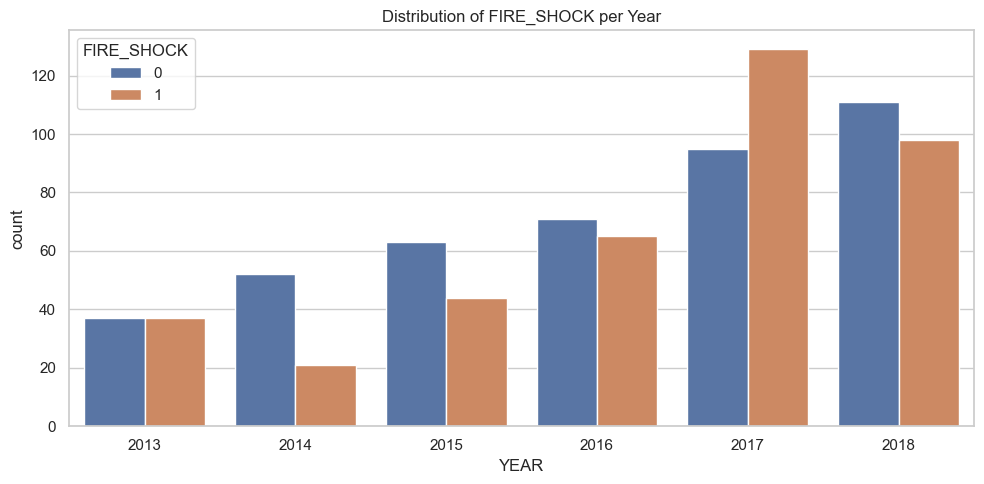

In [ ]:

# Display summary statistics and fire shock distribution
display(df[['PCT_PRICE_CHANGE (%)', 'NUM_FIRES', 'HOME_PRICE_LAG1', 'FIRE_SHOCK', 'FIRE_LAST_YEAR']].describe())

# Plot fire shock over years
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='YEAR', hue='FIRE_SHOCK')
plt.title("Distribution of FIRE_SHOCK per Year")
plt.tight_layout()
plt.show()


In [ ]:

# Step 1: Predict price change using only historical price info
X_price = df[['HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1']]
y = df['PCT_PRICE_CHANGE (%)']

price_model = LinearRegression()
price_model.fit(X_price, y)
df['price_pred'] = price_model.predict(X_price)
df['residual'] = y - df['price_pred']


In [ ]:

# Step 2: Use fire-related variables to predict the residual
fire_features = [
    'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE',
    'FIRE_SHOCK', 'FIRE_LAST_YEAR'
]
X_resid = df[fire_features]
y_resid = df['residual']

# Train XGBoost on residuals
tscv = TimeSeriesSplit(n_splits=CV_FOLDS)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED)

param_dist = {
    'n_estimators': randint(100, 800),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_lambda': uniform(0.5, 2.0),
    'reg_alpha': uniform(0, 1.0)
}

search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist,
    n_iter=N_ITER_TUNING, scoring='r2', cv=tscv,
    random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)
search.fit(X_resid, y_resid)
best_model = search.best_estimator_
df['resid_pred'] = best_model.predict(X_resid)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


Combined Model Evaluation:
RMSE: 3.9760
MAE : 2.8412
R²  : 0.4323


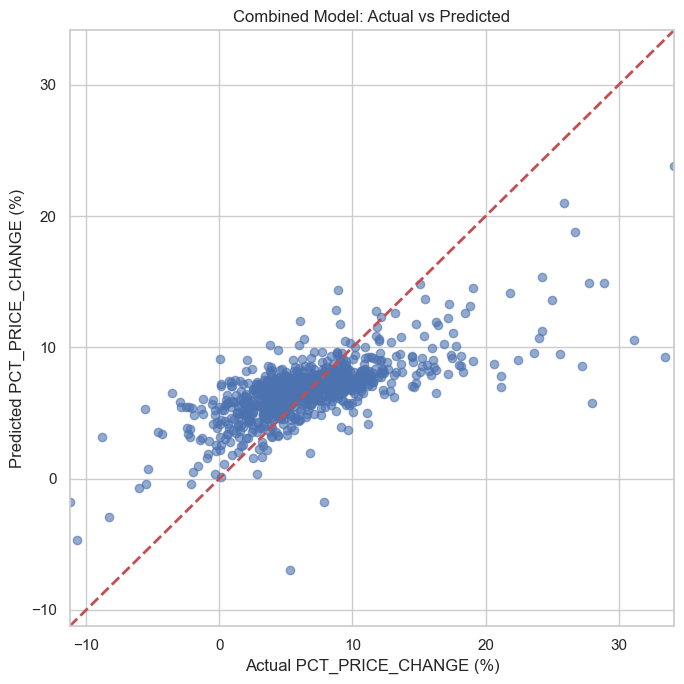

In [ ]:

# Final prediction = historical price model + residual prediction
df['final_pred'] = df['price_pred'] + df['resid_pred']

# Evaluate final model
rmse = np.sqrt(mean_squared_error(df['PCT_PRICE_CHANGE (%)'], df['final_pred']))
mae = mean_absolute_error(df['PCT_PRICE_CHANGE (%)'], df['final_pred'])
r2 = r2_score(df['PCT_PRICE_CHANGE (%)'], df['final_pred'])

print("Combined Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# Scatter plot of predicted vs actual
plt.figure(figsize=(7, 7))
plt.scatter(df['PCT_PRICE_CHANGE (%)'], df['final_pred'], alpha=0.6)
min_v = min(df['PCT_PRICE_CHANGE (%)'].min(), df['final_pred'].min())
max_v = max(df['PCT_PRICE_CHANGE (%)'].max(), df['final_pred'].max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=2)
plt.xlabel("Actual PCT_PRICE_CHANGE (%)")
plt.ylabel("Predicted PCT_PRICE_CHANGE (%)")
plt.title("Combined Model: Actual vs Predicted")
plt.grid(True)
plt.xlim(min_v, max_v)
plt.ylim(min_v, max_v)
plt.tight_layout()
plt.show()


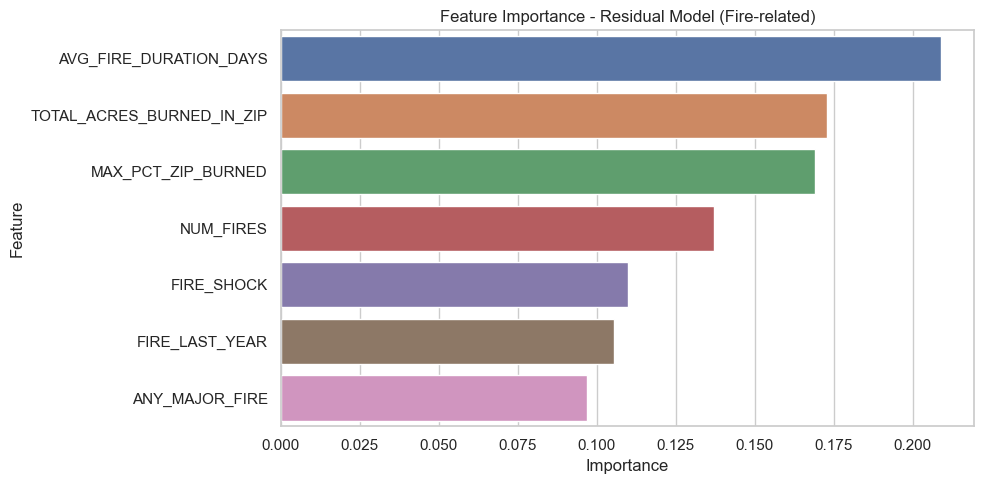

In [ ]:

# Show feature importance from XGBoost residual model
importances = best_model.feature_importances_
fi = pd.DataFrame({'Feature': fire_features, 'Importance': importances})
fi = fi.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=fi)
plt.title("Feature Importance - Residual Model (Fire-related)")
plt.tight_layout()
plt.show()
